### Importing Libraries.

In [425]:
# Pandas: This librarie will used to create and work with dataframes.
import pandas as pd 
# Matplotlib: Used to plot graphics. 
import matplotlib.pyplot as plt
# Seaborn: Used to better style and iprove graphics. 
import seaborn as sns
# Numpy for mathematic calculations. 
import numpy as np
#Tweepy: Used to work with the Twitter API.
import tweepy as tw
#ConfigParser: Used to get credentials for the twitter API.
import configparser as cp
#NLTK its used to pre-proccess text and regex its used to filter that text.
import nltk, re
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words = stopwords.words('english')
custom_stopwords = ["Tesla", "Ford", "tesla", "ford"]
normalizer = WordNetLemmatizer()
#Library to count words
from collections import Counter
# library to bluid wordclouds
from wordcloud import WordCloud
# NLTK to analice sentiment. 
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
#Another Library to perfom sentiment analisis.
from textblob import Word, TextBlob
# Library to build network graph.
from pyvis.network import Network
net = Network(notebook=True)
# NLTK library to builg ngrams.
from nltk.util import ngrams




[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Importing and authenticating API credentials from the config file. 

In [191]:
config =  cp.ConfigParser()
config.read("config.ini")

api_key = config["twitter"]["api_key"]
api_key_secret = config["twitter"]["api_key_secret"]
access_token = config["twitter"]["access_token"]
access_token_secret = config["twitter"]["access_token_secret"]

# Authentication

auth = tw.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

api = tw.API(auth)

### Funtions to work with in this project.

In [336]:

# Function to perform data extraction from twitter.
def scrape(words, date_since, numtweet):
# We are using .Cursor() to search
# through twitter for the required tweets.
# The number of tweets can be
# restricted using .items(number of tweets)
    tweets = tw.Cursor(api.search_tweets,
                               words, lang="en",
                               since_id=date_since,
                               tweet_mode='extended').items(numtweet)
# .Cursor() returns an iterable object. Each item in
# the iterator has various attributes
# that you can access to
# get information about each tweet
    list_tweets = [tweet for tweet in tweets]
 
# we will iterate over each tweet in the
# list for extracting information about each tweet
    columns=['tweet_date','tweets']
    data = []
    for tweet in list_tweets:
        tweet_date = tweet.created_at
# Retweets can be distinguished by
# a retweeted_status attribute,
# in case it is an invalid reference,
# except block will be executed
        try:
            tweets = tweet.retweeted_status.full_text
        except AttributeError:
            tweets = tweet.full_text
            data.append([tweet_date, tweets])
# Creating DataFrame using pandas
    df = pd.DataFrame(data, columns=columns)
    return df 

#Functions to preproccess text.
def get_part_of_speech(word):
  probable_part_of_speech = wordnet.synsets(word)
  pos_counts = Counter()
  pos_counts["n"] = len(  [ item for item in probable_part_of_speech if item.pos()=="n"]  )
  pos_counts["v"] = len(  [ item for item in probable_part_of_speech if item.pos()=="v"]  )
  pos_counts["a"] = len(  [ item for item in probable_part_of_speech if item.pos()=="a"]  )
  pos_counts["r"] = len(  [ item for item in probable_part_of_speech if item.pos()=="r"]  )
  most_likely_part_of_speech = pos_counts.most_common(1)[0][0]
  return most_likely_part_of_speech

def preprocess_text(text, custom_stopword):
  cleaned = re.sub(r'(\W+)|(http\S+)', ' ', text).lower()
  tokenized = word_tokenize(cleaned)
  normalized = [normalizer.lemmatize(token, get_part_of_speech(token)) for token in tokenized if token not in stop_words]
  normalized = [token for token in normalized if token not in custom_stopword]
  return normalized

# Cleaning text. 
def clean_text(text, custom_stopword):
  cleaned = re.sub(r'(\W+)|(http\S+)', ' ', text).lower()
  cleaned = " ".join(word for word in cleaned.split() if word not in stop_words)
  cleaned = " ".join(word for word in cleaned.split() if word not in custom_stopwords)
  cleaned = " ".join(normalizer.lemmatize(word, get_part_of_speech(word)) for word in cleaned.split())
  return cleaned

# Funtion to bluid and plot a WordCloud.
def wordcloud(str1, str2):
    wordcloud1 = WordCloud (
                    background_color = 'white',
                    width = 512,
                    height = 384
                        ).generate(' '.join(str1))
    wordcloud2 = WordCloud (
                    background_color = 'white',
                    width = 512,
                    height = 384
                        ).generate(' '.join(str2))
#plot the wordcloud object
    plt.figure(figsize = (15,10))
    plt.subplot(1,2,1)
    plt.title("Tesla WordCloud")
    plt.imshow(wordcloud1, interpolation='bilInear')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title("Ford WordCloud")
    plt.imshow(wordcloud2, interpolation='bilInear')
    plt.axis('off')
    plt.show()

#Sentiment finder
def sentiment(text):
    score = sia.polarity_scores(text)
    pos = score["pos"]
    neg = score["neg"]
    if pos > neg:
        sentiment = "positive"
    elif neg > pos:
        sentiment = "negative"
    else:
        sentiment = "neutral"
    return sentiment


### Getting the data from twitter.

In [293]:
tesla = scrape("Tesla", 2022-0o1-0o1, 1000)
ford = scrape("Ford", 2022-0o1-0o1, 1000)

### Preproccessing the data for further analisys.

In [324]:
tesla_preprocess = preprocess_text("".join(tesla.tweets), custom_stopwords)
ford_preprocess = preprocess_text("".join(ford.tweets), custom_stopwords)

['mwt2008',
 'ask',
 'would',
 'save',
 'fully',
 'charge',
 'peak',
 'peak',
 'car',
 'starship',
 'rocket',
 'iphone',
 'mobile',
 'bsc',
 'ghc',
 'realmeetkevin',
 'pay',
 'money',
 'essentially',
 'play',
 'game',
 'get',
 'safety',
 'score',
 'hop',
 'unlock',
 'full',
 'self',
 'drive',
 'grade',
 'school',
 'seem',
 'like',
 'gatekeep',
 'control',
 'freedom',
 'realize',
 'b',
 'disappointment',
 'thedoctorpk_',
 'killo15',
 'itskongming',
 'shortword',
 'elonmusk',
 'johnchen',
 'globally',
 'upon',
 'inside',
 'gear',
 'jeremy',
 'kidnap',
 '2',
 'russian',
 'slave',
 'richard',
 'dumbassedly',
 'run',
 '1649',
 'honda',
 'civic',
 'james',
 'explode',
 'c4',
 '85',
 'preschooler',
 'dictionaryhill',
 'tommolog',
 'last',
 'choice',
 'buddy',
 'cheap',
 'interior',
 'worst',
 'ride',
 'quality',
 'horrible',
 'customer',
 'service',
 'build',
 'quality',
 'bottom',
 'barrel',
 'want',
 'see',
 'corolla',
 'ev',
 'sdteslaowners',
 'ptpetra',
 'rentpacificride',
 'dictionaryhil

### Counting words with bag of words

In [308]:
tesla_bow = Counter(tesla_preprocess)
ford_bow = Counter(ford_preprocess)

print("\nThen most frequent words and number of occurrences for Tesla according to Bag-of-Words:")
most_common_tesla = tesla_bow.most_common(10)
print(most_common_tesla)
print("\nTen most frequent words and number of occurrences for Ford according to Bag-of-Words:")
most_common_ford = ford_bow.most_common(10)
print(most_common_ford)


Then most frequent words and number of occurrences for Tesla according to Bag-of-Words:
[('elonmusk', 153), ('car', 60), ('get', 53), ('like', 49), ('make', 45), ('elon', 43), ('would', 34), ('ev', 33), ('u', 33), ('buy', 32)]

Ten most frequent words and number of occurrences for Ford according to Bag-of-Words:
[('like', 16), ('coppola', 15), ('one', 15), ('francis', 14), ('get', 14), ('know', 14), ('ebay', 14), ('deal', 14), ('amp', 13), ('car', 13)]


### Building a WordCloud

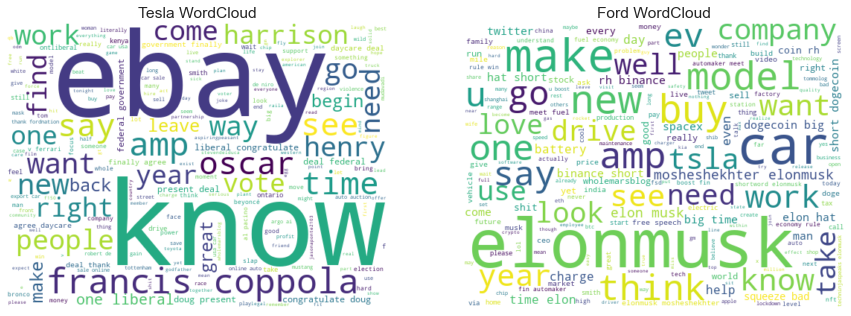

In [323]:
wordcloud(ford_preprocess, tesla_preprocess)

### Finding the sentiment of each tweet using nltk SentimentIntensityAnalyzer

In [337]:
# In this case we just need to clean the data and create a new column with it.
tesla["clean_tweet"] = tesla["tweets"].apply(lambda x: clean_text(x, custom_stopwords))
ford["clean_tweet"] = ford["tweets"].apply(lambda x: clean_text(x, custom_stopwords))
# Now we can apply the sentiment function and create a new column with it.
tesla["sentiment"] = tesla["clean_tweet"].apply(sentiment)
ford["sentiment"] = ford["clean_tweet"].apply(sentiment)
print(ford.tail())
print(tesla.tail())

                   tweet_date  \
227 2022-03-28 04:22:27+00:00   
228 2022-03-28 04:22:07+00:00   
229 2022-03-28 04:21:20+00:00   
230 2022-03-28 04:21:18+00:00   
231 2022-03-28 04:21:09+00:00   

                                                tweets  \
227  @MaryS910 @dantivirus @ArleneCrandall @Michael...   
228  100,000-Mile, 22-Year-Old #Ford Excursion Sell...   
229  For everyone working on their “this is Oscars ...   
230   @kensmith_ken Ford’s a little smarter than Tyler   
231          @Valerie55589711 I am so incredibly sorry   

                                           clean_tweet sentiment  
227  marys910 dantivirus arlenecrandall michaelstee...  positive  
228  100 000 mile 22 year old excursion sell bring ...   neutral  
229  everyone work oscar dark moment piece let reme...  positive  
230                    kensmith_ken little smart tyler  positive  
231                   valerie55589711 incredibly sorry  negative  
                   tweet_date  \
464 2022-03-28 04

### Sentiment count per company.

In [270]:
# Total sentiment count
sentiment_count_tesla =  tesla.groupby('sentiment')['sentiment'].count()
sentiment_count_ford =  ford.groupby('sentiment')['sentiment'].count()
#Creating a df with that count to plot later. 
total_sentiments_tesla = sentiment_count_tesla.to_frame()
total_sentiments_tesla.rename(columns={"sentiment":"count"}, inplace=True)
total_sentiments_tesla.reset_index(inplace=True)

total_sentiments_ford = sentiment_count_ford.to_frame()
total_sentiments_ford.rename(columns={"sentiment":"count"}, inplace=True)
total_sentiments_ford.reset_index(inplace=True)

print("Total sentiment count of Ford:")
print(total_sentiments_ford)
print("\nTotal sentiment count of Tesla: ")
print(total_sentiments_tesla)

# Sentiment count by day
day_tesla_sentiment_count = tesla.groupby([pd.Grouper(key='tweet_date', axis=0, 
                      freq='D', sort=True), "sentiment"])['sentiment'].count()
day_ford_sentiment_count = ford.groupby([pd.Grouper(key='tweet_date', axis=0, 
                      freq='D', sort=True), "sentiment"])['sentiment'].count()
#day_tesla_sentiment_count

Total sentiment count of Ford:
  sentiment  count
0  negative     85
1   neutral    130
2  positive    169

Total sentiment count of Tesla: 
  sentiment  count
0  negative     82
1   neutral    116
2  positive    253


### Sentiments BarCharts

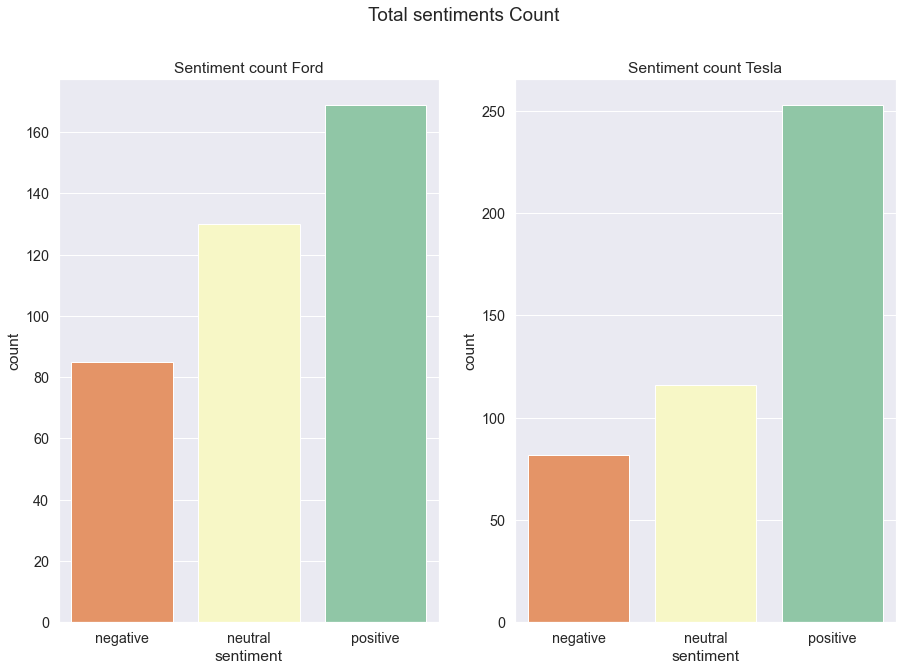

In [418]:
# Convetir en una funcion. 

plt.figure(figsize=(15,10))
plt.suptitle("Total sentiments Count")
plt.subplot(1,2,1)
plt.title("Sentiment count Ford")
sns.barplot(x="sentiment", y="count", data=total_sentiments_ford, palette="Spectral")
plt.subplot(1,2,2)
plt.title("Sentiment count Tesla")
sns.barplot(x="sentiment", y="count", data=total_sentiments_tesla, palette="Spectral")
plt.show()

### Finding the sentiment of each tweet using TextBlob
#### Polarity: range from -1 to 1, being -1 the most negative sentiment and 1 the most positive.
#### Subjectivity: quantifies the amount of personal opinion and factual information contained in the text. The higher subjectivity means that the text contains personal opinion rather than factual information.

In [373]:
tesla["polarity"] = tesla["clean_tweet"].apply(lambda x: TextBlob(x).sentiment[0])
tesla["subjectivity"] = tesla["clean_tweet"].apply(lambda x: TextBlob(x).sentiment[1])
ford["polarity"] = ford["clean_tweet"].apply(lambda x: TextBlob(x).sentiment[0])
ford["subjectivity"] = ford["clean_tweet"].apply(lambda x: TextBlob(x).sentiment[1])
tesla.head()

,tweet_date,tweets,clean_tweet,sentiment,polarity,subjetivity,subjectivity
0,2022-03-28 05:13:58+00:00,@mwt2008 Can i ask what would be the saving to...,mwt2008 ask would save fully charge peak peak,positive,0.0000,0.0000,0.0000
1,2022-03-28 05:13:58+00:00,"Tesla in Cars, Starship in rockets, iPhone in ...",car starship rocket iphone mobile bsc ghc,neutral,0.0000,0.0000,0.0000
2,2022-03-28 05:13:17+00:00,@realMeetKevin What? You pay all that money? T...,realmeetkevin pay money essentially play game ...,positive,-0.1625,0.4125,0.4125
3,2022-03-28 05:13:17+00:00,@TheDoctorPK_ @killo15 @itsKongming @shortword...,thedoctorpk_ killo15 itskongming shortword elo...,neutral,0.0000,0.0000,0.0000
4,2022-03-28 05:13:09+00:00,"Now, upon Inside Gear, Jeremy kidnaps 2 Russia...",upon inside gear jeremy kidnap 2 russian slave...,neutral,0.0000,0.0000,0.0000


### Mean and Median of Polarity and subjectivity by brand.

In [367]:
print("Tesla")
display(tesla[["polarity", "subjectivity"]].agg([np.mean, np.median]))
print("Ford")
ford[["polarity", "subjectivity"]].agg([np.mean, np.median])

Tesla


,polarity,subjectivity
mean,0.071152,0.355941
median,0.000000,0.375000


Ford


,polarity,subjectivity
mean,0.0948,0.342879
median,0.0000,0.350758


### Visualizing the moving average of the sentiments.

In [379]:
# Building dtaframes for the visualization. 
tesla_ma = tesla[["tweet_date", "polarity"]]
tesla_ma = tesla_ma.sort_values(by="tweet_date", ascending=True)
tesla_ma["MA Polarity"] = tesla_ma.polarity.rolling(10, min_periods=3).mean()

ford_ma = ford[["tweet_date", "polarity"]]
ford_ma = ford_ma.sort_values(by="tweet_date", ascending=True)
ford_ma["MA Polarity"] = ford_ma.polarity.rolling(10, min_periods=3).mean()


,tweet_date,polarity,MA Polarity
231,2022-03-28 04:21:09+00:00,-0.500000,NaN
230,2022-03-28 04:21:18+00:00,0.013393,NaN
229,2022-03-28 04:21:20+00:00,-0.158333,-0.214980
228,2022-03-28 04:22:07+00:00,0.100000,-0.136235
227,2022-03-28 04:22:27+00:00,0.300000,-0.048988
...,...,...,...
4,2022-03-28 05:13:13+00:00,0.000000,-0.017214
3,2022-03-28 05:13:16+00:00,0.187500,0.001536
2,2022-03-28 05:13:20+00:00,0.093750,0.010911
1,2022-03-28 05:13:20+00:00,0.000000,0.005911


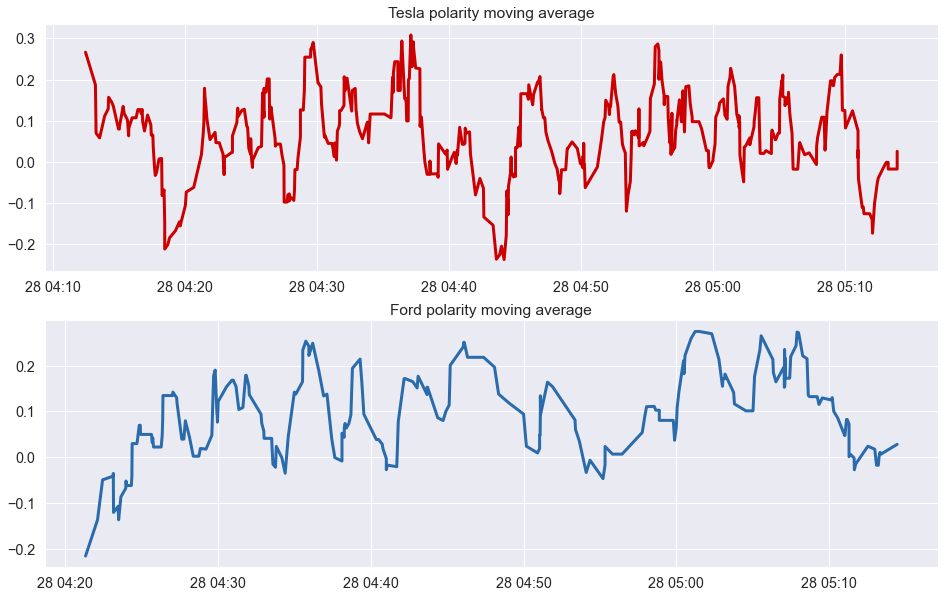

In [420]:
#Plotting both graph with matplotib. 

fig, ax = plt.subplots(2, 1, figsize=(16,10))
ax[0].plot(tesla_ma["tweet_date"], tesla_ma["MA Polarity"], color="#cc0000")
ax[0].set_title("Tesla polarity moving average")

ax[1].plot(ford_ma["tweet_date"], ford_ma["MA Polarity"], color="#2A6BAC")
ax[1].set_title("Ford polarity moving average")

plt.show()

### Visualizing Subjectivity and Polarity 

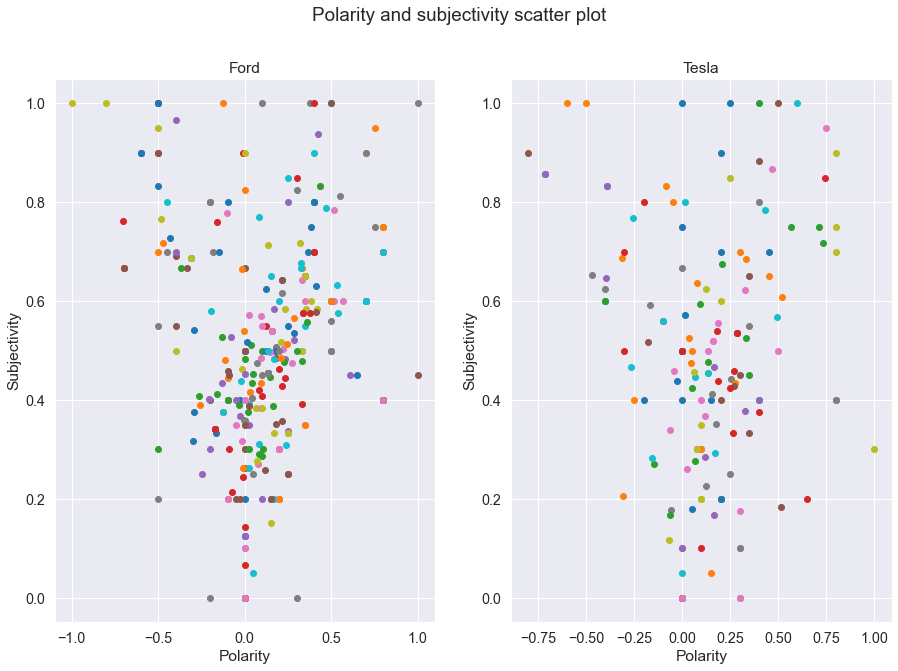

In [407]:
#Plotting the both graph. 

plt.figure(figsize=(15,10))
plt.suptitle("Polarity and subjectivity scatter plot")
plt.subplot(1,2,1)
plt.title("Ford")
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
for i in range(len(tesla)):
    plt.scatter(x=tesla["polarity"][i], y=tesla["subjectivity"][i])
plt.subplot(1,2,2)
plt.xlabel("Polarity")
plt.ylabel("Subjectivity")
for i in range(len(ford)):
    plt.scatter(x=ford["polarity"][i], y=ford["subjectivity"][i])
plt.title("Tesla")
plt.show()

### Lista de palabras por sentimiento y comparar si se mezclan

In [424]:
net.from_nx(tesla)

AssertionError: 

### 2-Grams y 3-Grams y graficar como se conectan.

In [431]:
# Bigram
bigrams_prepped = ngrams(tesla_preprocess, 2)
bigrams = Counter(bigrams_prepped)
print("Five most frequent word sequences and the number of occurrences according to Bigrams:")
print(bigrams.most_common(5))

bigrams_prepped = ngrams(ford_preprocess, 2)
bigrams = Counter(bigrams_prepped)
print("Five most frequent word sequences and the number of occurrences according to Bigrams:")
print(bigrams.most_common(5))

#Threegram
threegram_prepped = ngrams(tesla_preprocess, 3)
threegrams = Counter(threegram_prepped)
print("Five most frequent word sequences and the number of occurrences according to Bigrams:")
print(threegrams.most_common(5))

threegrams_prepped = ngrams(ford_preprocess, 3)
threegrams = Counter(threegrams_prepped)
print("Five most frequent word sequences and the number of occurrences according to Bigrams:")
print(threegrams.most_common(5))

Five most frequent word sequences and the number of occurrences according to Bigrams:
[(('mosheshekhter', 'elonmusk'), 17), (('elon', 'musk'), 17), (('time', 'elon'), 14), (('rh', 'binance'), 13), (('binance', 'short'), 13)]
Five most frequent word sequences and the number of occurrences according to Bigrams:
[(('francis', 'coppola'), 14), (('one', 'liberal'), 7), (('liberal', 'congratulate'), 7), (('congratulate', 'doug'), 7), (('doug', 'present'), 7)]
Five most frequent word sequences and the number of occurrences according to Bigrams:
[(('rh', 'binance', 'short'), 13), (('binance', 'short', 'dogecoin'), 13), (('short', 'dogecoin', 'big'), 13), (('dogecoin', 'big', 'time'), 13), (('big', 'time', 'elon'), 13)]
Five most frequent word sequences and the number of occurrences according to Bigrams:
[(('one', 'liberal', 'congratulate'), 7), (('liberal', 'congratulate', 'doug'), 7), (('congratulate', 'doug', 'present'), 7), (('doug', 'present', 'deal'), 7), (('present', 'deal', 'federal'), 